# Исследование покупательской активности интернет-магазина

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории.

Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Цель проекта разработать модель , которая предскажет вероятность снижения покупательской активности. И на основе результата модели выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность.

## Описание данных

Таблица `market_file.csv`, содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- `id` - номер покупателя в корпоративной базе данных.
- `Покупательская активность` - рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` - уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` - информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` - количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` - самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` - показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` - общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` - число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица `market_money.csv` с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- `id` - номер покупателя в корпоративной базе данных.
- `Период` - название периода, во время которого зафиксирована выручка. Например, `'текущий_месяц'` или `'предыдущий_месяц'`.
- `Выручка` - сумма выручки за период.

Таблица `market_time.csv` с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- `id` - номер покупателя в корпоративной базе данных.
- `Период` - название периода, во время которого зафиксировано общее время.
- `минут` - значение времени, проведённого на сайте, в минутах.

Таблица `money.csv` с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- `id` - номер покупателя в корпоративной базе данных.
- `Прибыль` - значение прибыли.

## План работы

1. Изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

# Технический блок

Раздел отвечает за хранение подключений и загрузку требуемых инструментов и файлов. Так же здесь будут расположены подготовленные или часто используемые функции, константы и другие участки кода.

## Настройки

In [ ]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Дополнительные модули

In [ ]:
!pip install phik -q;
!pip install scikit-learn -q;
!pip install shap -q;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 6.0 MB/s eta 0:00:00


## Модули

In [ ]:
# Глобальные модули
import pandas as pd
import seaborn as sns
import numpy as np
import phik
import time
import shap
import re

from phik import phik_matrix
from matplotlib import pyplot as plt
from scipy.stats import norm

# Модели машинного обучения
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Пайплайн, масштабирование и кодирование
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
)

# Подготовка и оценка
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)

# Метрика качества
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    r2_score,
    precision_recall_curve,
    make_scorer,
    fbeta_score,
)

In [ ]:
# Константы моделирования
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal = '.')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal = '.')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal = '.')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

## Функции

In [ ]:
def get_data_view(df: pd.DataFrame) -> None:
    """Функция для вывода основной информации о датафрейме."""

    display(df.head(5))
    print('-' * 100)
    display(df.info())
    print('-' * 100)
    print(f'Количество явных дубликатов: {df.duplicated().sum()}')

In [ ]:
def get_duplicated_column(df: pd.DataFrame, types: str = 'object') -> None:
    """Функция для вывода уникальных значений датафрейма."""

    for name in df.select_dtypes(include=types).columns.to_list():
        print(f'Столбец {name}: {df[name].unique()}')

In [ ]:
def get_graph_plot(df: pd.DataFrame, column: str) -> None:
    """Функция построения гистограммы и диаграммы размаха."""

    # Рассчитываем среднее и стандартное отклонение для нормального распределения
    mean = df[column].mean()
    std = df[column].std()

    # Создаем сетку значений по оси X
    x = np.linspace(df[column].min(), df[column].max(), 100)
    y = norm.pdf(x, mean, std) * len(df[column]) * (df[column].max() - df[column].min()) / 40  # Подгоняем масштаб

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    plt.subplots_adjust(right=0.5)

    sns.histplot(df[column], ax=axs[0], bins=40, kde=True, color='skyblue', shrink=0.8)
    axs[0].axvline(df[column].mean(), color='red', linestyle='--', label='Среднее')
    axs[0].axvline(df[column].median(), color='orange', linestyle='-', label='Медиана')
    axs[0].plot(x, y, color='green', label='Нормальное распределение')

    axs[0].set_title(f'Гистограмма признака {column}')
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Количество')
    axs[0].legend(fontsize=10)

    sns.boxplot(x=df[column], ax=axs[1], color='lightgreen')
    axs[1].set_title(f'Диаграмма размаха для {column}')

    plt.tight_layout()
    plt.show()

In [ ]:
def get_graph_plot_ml(df: pd.DataFrame, column: str, threshold: int) -> None:
    """Функция построения двойной гистограммы."""

    threshold_down = df[df['вероятность_снижения'] < threshold]
    threshold_up = df[df['вероятность_снижения'] >= threshold]

    plt.figure(figsize=(15, 5))
    sns.histplot(threshold_down[column], color='blue', label=f'Меньше {threshold}%', kde=True, alpha=0.5)
    sns.histplot(threshold_up[column], color='red', label=f'Больше {threshold}%', kde=True, alpha=0.5)

    plt.xlabel(column)
    plt.ylabel("Частота")
    plt.title(f"Распределение {column} для групп <= {threshold}% и > {threshold}%")
    plt.legend()
    plt.show()

In [ ]:
def get_graph_bar(df: pd.DataFrame, column: str) -> None:
    """Функция построения графика для дискретных значений и диаграммы размаха."""

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    sns.countplot(x=df[column], ax=axs[0], edgecolor='black', linewidth=1)
    axs[0].set_title(f'Гистограмма распределения для {column}')
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Количество')

    sns.boxplot(x=df[column], ax=axs[1], color='lightgreen')
    axs[1].set_title(f'Диаграмма размаха для {column}')

    plt.tight_layout()
    plt.show()

In [ ]:
def get_graph_pie(data: pd.DataFrame, x: str, explode_ratio: float = 0.03, palette_name: str = 'pastel'):
    """Функция для построения стильной круговой диаграммы."""

    plt.figure(figsize=(15, 5))
    plt.rcParams['font.size'] = 14

    # Подготовка данных
    counts = data[x].value_counts()
    labels = counts.index
    sizes = counts.values

    # Стилизация
    colors = sns.color_palette(palette_name, len(counts))
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=labels,
        startangle=90,
        autopct='%1.2f%%',
        pctdistance=0.75,
        labeldistance=1.05,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},
        textprops={'color': 'dimgrey', 'fontweight': 'semibold'},
        shadow=False
    )

    # Настройка процентов
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(13)

    # Заголовок и выравнивание
    plt.title(x, fontsize=20, pad=20, fontweight='bold', color='dimgrey')

    # Центральный круг
    centre_circle = plt.Circle((0,0), 0.4, fc='white')  # Уменьшенный радиус
    plt.gca().add_artist(centre_circle)

    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# 1. Изучение данных

In [ ]:
get_data_view(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  


None

----------------------------------------------------------------------------------------------------
Количество явных дубликатов: 0


In [ ]:
get_data_view(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

----------------------------------------------------------------------------------------------------
Количество явных дубликатов: 0


In [ ]:
get_data_view(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

----------------------------------------------------------------------------------------------------
Количество явных дубликатов: 0


In [ ]:
get_data_view(money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

----------------------------------------------------------------------------------------------------
Количество явных дубликатов: 0


## Вывод

Все загруженные файлы не содержат пропусков, явных дубликатов, тип данных столбца соответствует хранимой в нём информации. Среди недостатков можно выделить следующее.

- Наименование столбцов на русском языке.
- Наличие символа пробела в названиях столбцов.

Наименования мы оставим как есть для сохранения интерпретации, но сменим на нижний регистр и заменим пробел на нижнее подчеркивание.

# 2. Предобработка данных

Проверим данные на наличие неявных дубликатов, а так же для повышения удобства дальнейшей работы приведём все названия столбцов к нижнему регистру с заменой символа пробела на нижнее подчеркивание. Столбцы с типом `object` так же приведём к нижнему регистру для исключения ошибок записи данных.

In [ ]:
for df in [market_file, market_money, market_time, money]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

In [ ]:
for df in [market_file, market_money, market_time, money]:
    print(df.columns)
    print('-' * 25)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
-------------------------
Index(['id', 'период', 'выручка'], dtype='object')
-------------------------
Index(['id', 'период', 'минут'], dtype='object')
-------------------------
Index(['id', 'прибыль'], dtype='object')
-------------------------


### Файл `market_file`

In [ ]:
column_name = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

for name in column_name:
    market_file[name] = market_file[name].str.lower()

In [ ]:
get_duplicated_column(market_file)

Столбец покупательская_активность: ['снизилась' 'прежний уровень']
Столбец тип_сервиса: ['премиум' 'стандартт' 'стандарт']
Столбец разрешить_сообщать: ['да' 'нет']
Столбец популярная_категория: ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


In [ ]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['популярная_категория'] = market_file['популярная_категория'].replace('косметика и аксесуары', 'косметика и аксессуары')

### Файл `market_money`

In [ ]:
get_duplicated_column(market_money)

Столбец период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


### Файл `market_time`

In [ ]:
get_duplicated_column(market_time)

Столбец период: ['текущий_месяц' 'предыдцщий_месяц']


In [ ]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

## Общая проверка дубликатов

In [ ]:
for df in [market_file, market_money, market_time, money]:
    display(f'Количество дубликатов {df.duplicated().sum()}')

'Количество дубликатов 0'

'Количество дубликатов 0'

'Количество дубликатов 0'

'Количество дубликатов 0'

## Вывод

На этапе предобработки данных были проверены все файлы на наличие обоих типов дубликатов, а все строковые данные приведены к нижнему регистру. Исходные данные оказались хорошего качества лишь с незначительными ошибками:

- Столбец `тип_сервиса` в файле `market_file` - Орфографическая ошибка.
- Столбец `период` в файле `market_time` - Орфографическая ошибка.

Другие проблемы в данных отсутствуют, наличие выбросов будет проверено на этапе исследовательского анализа.

# 3. Исследовательский анализ данных

Исследовательский анализ проведём на актуальной клиентской выборке, а именно на группе клиентов совершившие не менее одной покупки на протяжении трёх месяцев.

In [ ]:
id_clients_noactiv = market_money.loc[market_money['выручка'] == 0, 'id'].unique()

datasets = [market_file, market_money, market_time, money]
filtered_datasets = [df.loc[~df['id'].isin(id_clients_noactiv)] for df in datasets]

market_file_a, market_money_a, market_time_a, money_a = filtered_datasets

## Файл `market_file`

### Признак `покупательская_активность`

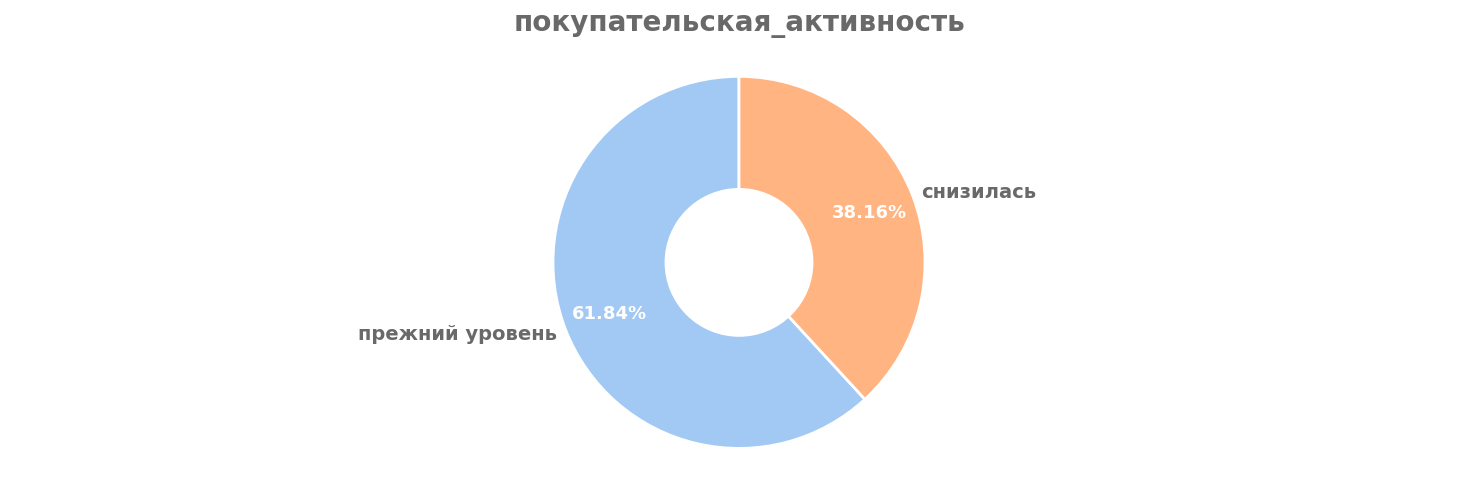

In [ ]:
get_graph_pie(market_file_a, 'покупательская_активность')

Целевой признак `покупательская_активность` представлен как биноминальный, с соотношением 69% на 38% пускай и положительным фактом для магазина, но  с выраженным дисбалансом классов для будущей модели. Учтём это на будущее.

### Признак `тип_сервиса`

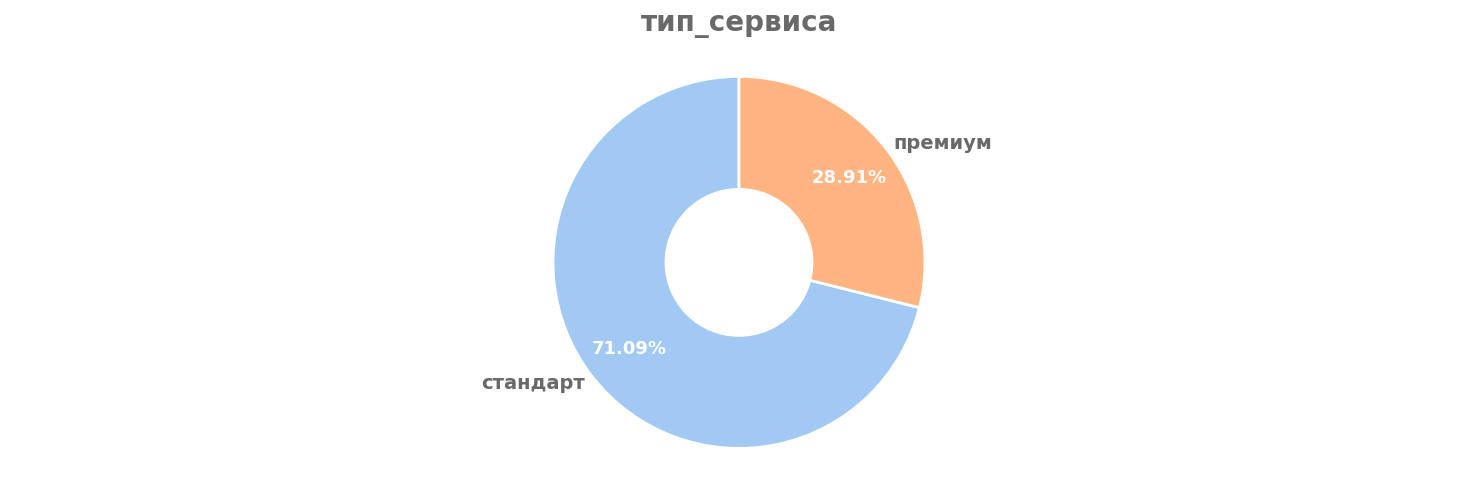

In [ ]:
get_graph_pie(market_file_a, 'тип_сервиса')

Признак `тип_сервиса` так же является биноминальным, с более выраженным дисбалансом при соотношении 71% на 29%.

### Признак `разрешить_сообщать`

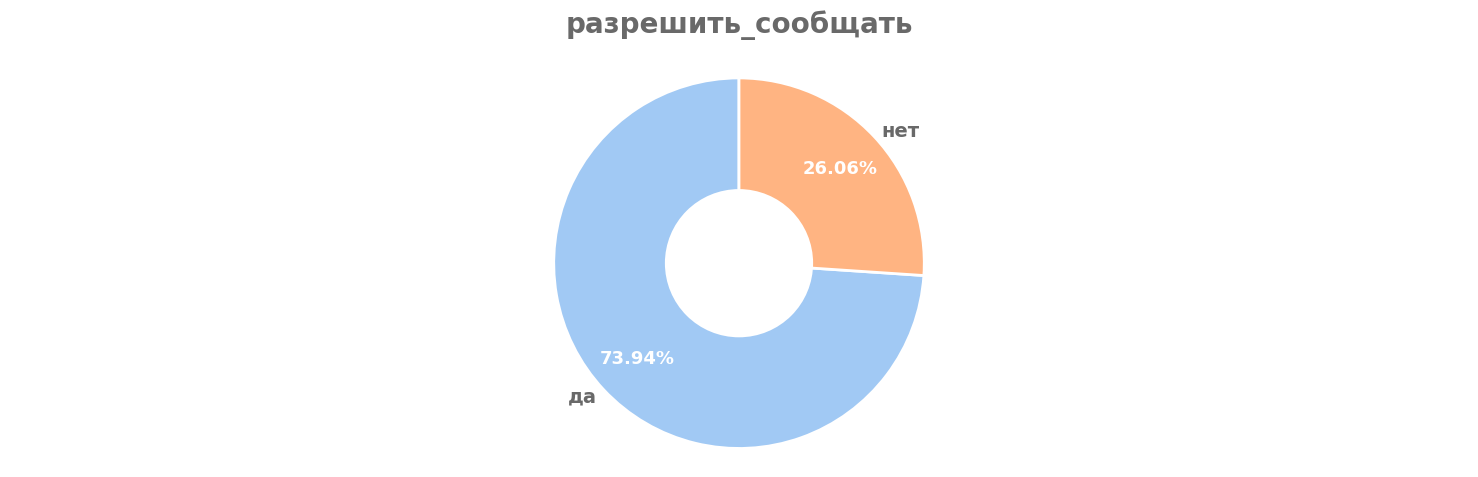

In [ ]:
get_graph_pie(market_file_a, 'разрешить_сообщать')

Признак `разрешить_сообщать` так же является биноминальным с выраженным дисбалансом классов при соотношении 74% на 26%.

### Признак `маркет_актив_6_мес`

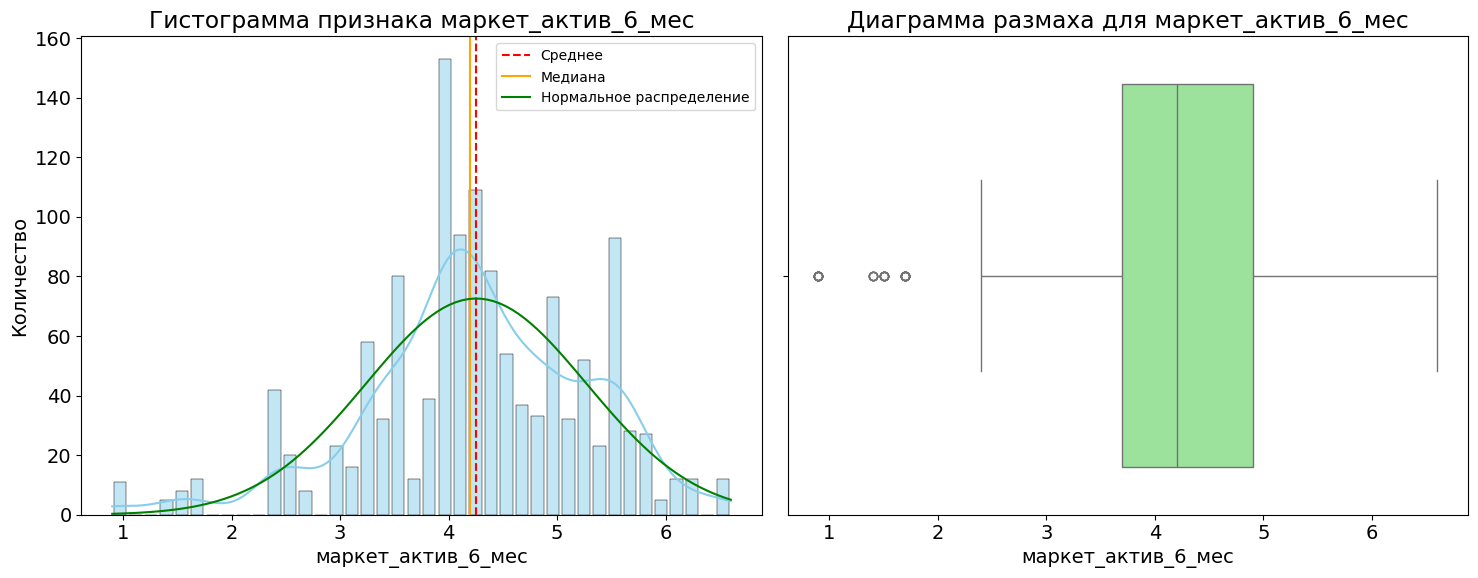

In [ ]:
get_graph_plot(market_file_a, 'маркет_актив_6_мес')

In [ ]:
market_file_a['маркет_актив_6_мес'].describe()

,маркет_актив_6_мес
count,1297.000000
mean,4.254433
std,1.015618
min,0.900000
25%,3.700000
50%,4.200000
75%,4.900000
max,6.600000


Данные маркетинговой активности за 6 месяцев при визуальной оценке распределены не нормально с смещением вправо, наблюдаются высокие пики на некоторое количество клиентов.

### Признак `маркет_актив_тек_мес`

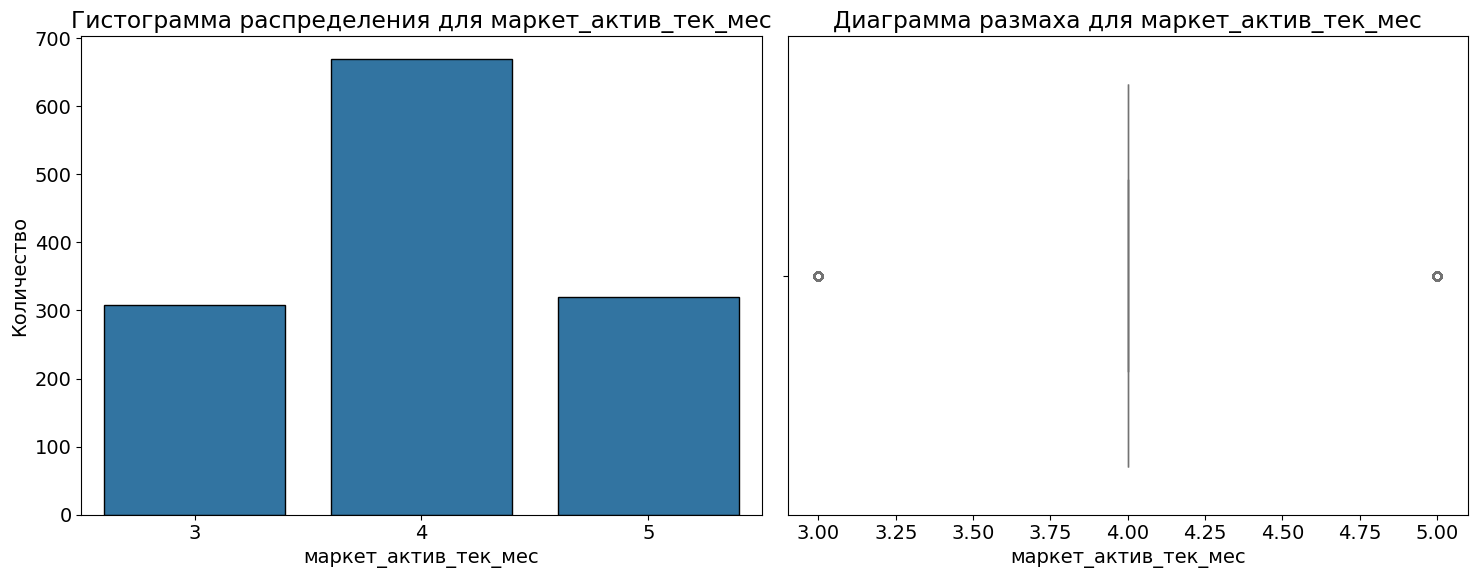

In [ ]:
get_graph_bar(market_file_a, 'маркет_актив_тек_мес')

Маркетинговая активность текущего месяца принимает дискретные целочисленные значения и в целом отражает распределение признака `маркет_актив_6_мес`.

### Признак `длительность`

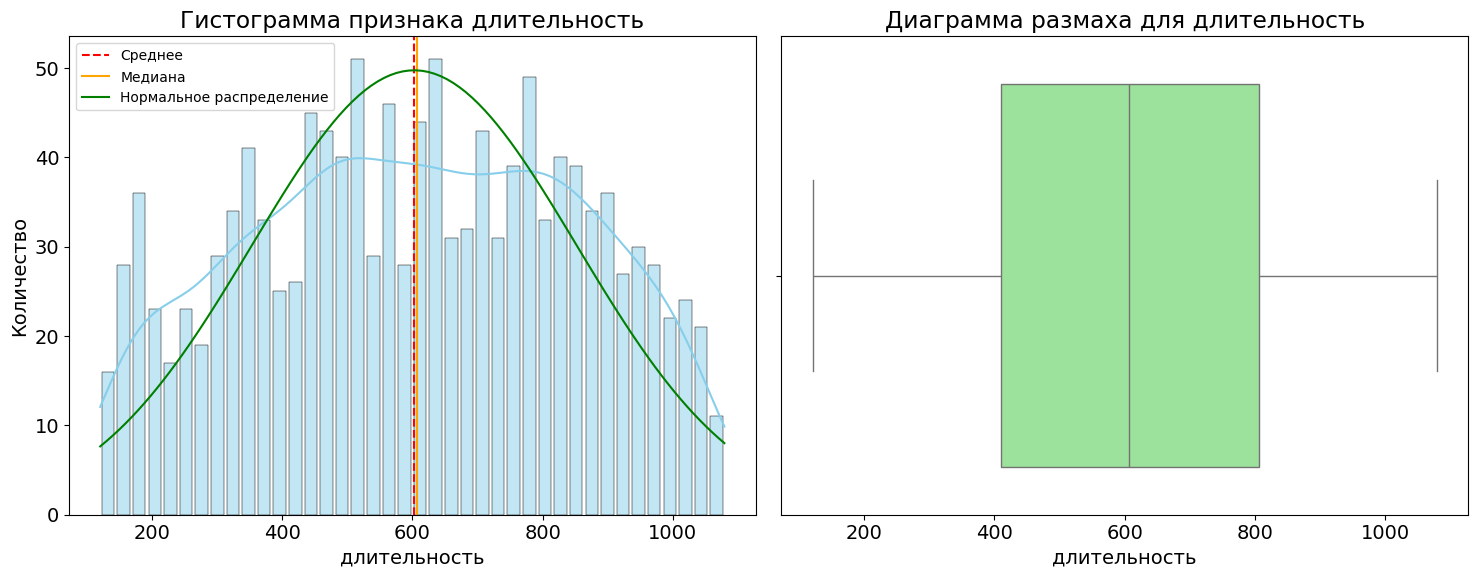

In [ ]:
get_graph_plot(market_file_a, 'длительность')

In [ ]:
market_file_a['длительность'].describe()

,длительность
count,1297.000000
mean,602.993832
std,249.101456
min,121.000000
25%,410.000000
50%,607.000000
75%,806.000000
max,1079.000000


Распределение признака ненормальное из представленных данных складывается предположение, что основная масса клиентов была зарегистрирована в один период и компания не проводила активных программ для привлечения новых клиентов или делала это безрезультатно.

### Признак `акционные_покупки`

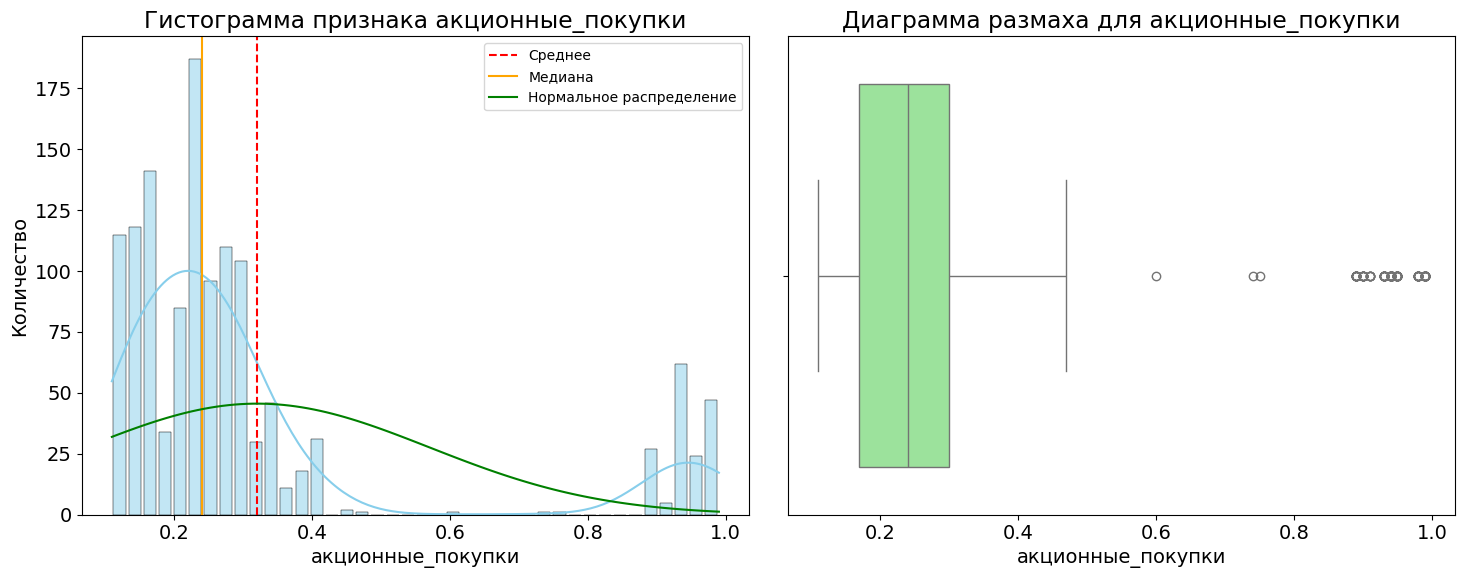

In [ ]:
get_graph_plot(market_file_a, 'акционные_покупки')

In [ ]:
print(f"Количество клиентов с долей акциооных покупок больше 80%: {len(market_file_a.loc[market_file_a['акционные_покупки'] >= 0.8])}")

Количество клиентов с долей акциооных покупок больше 80%: 165


Анализ доли акционных покупок клиентов указывает на наличие двух пиков, где всего 165 клиентов в 80% совершают покупки акционных товаров. Для остальных клиентов такие покупки не провещают 30%.

### Признак `популярная_категория`

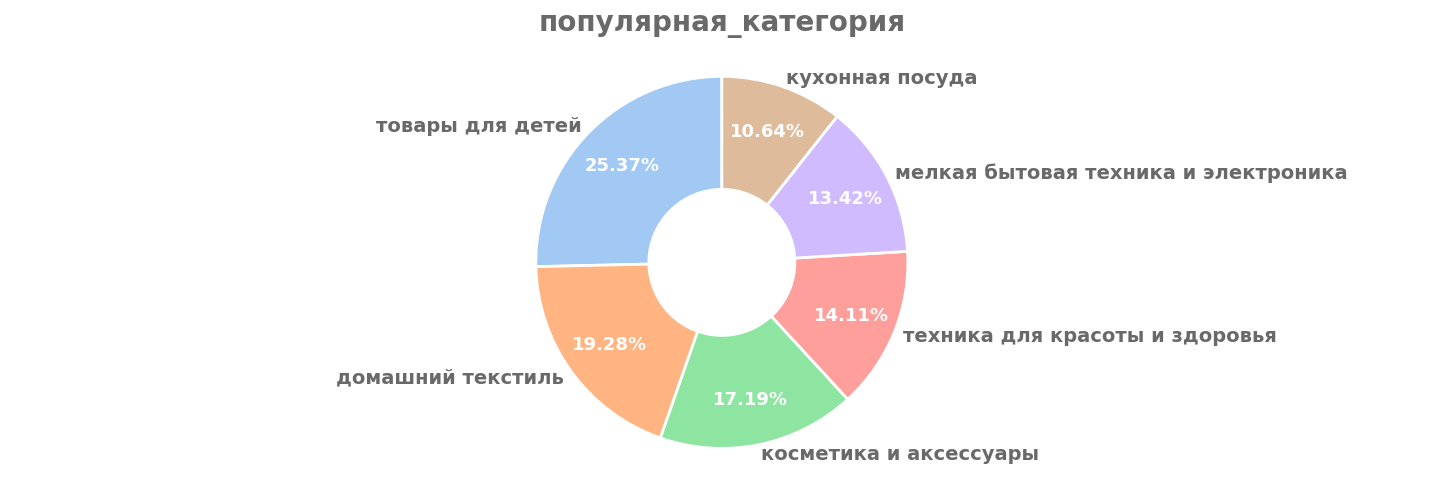

In [ ]:
get_graph_pie(market_file_a, 'популярная_категория')

Доли популярных категорий за 6 месяцев относительно равномерно распределены выделяющейся категорией можно считать `товары для детей`. Всего в наборе представлено 6 классов.

### Признак `средний_просмотр_категорий_за_визит`

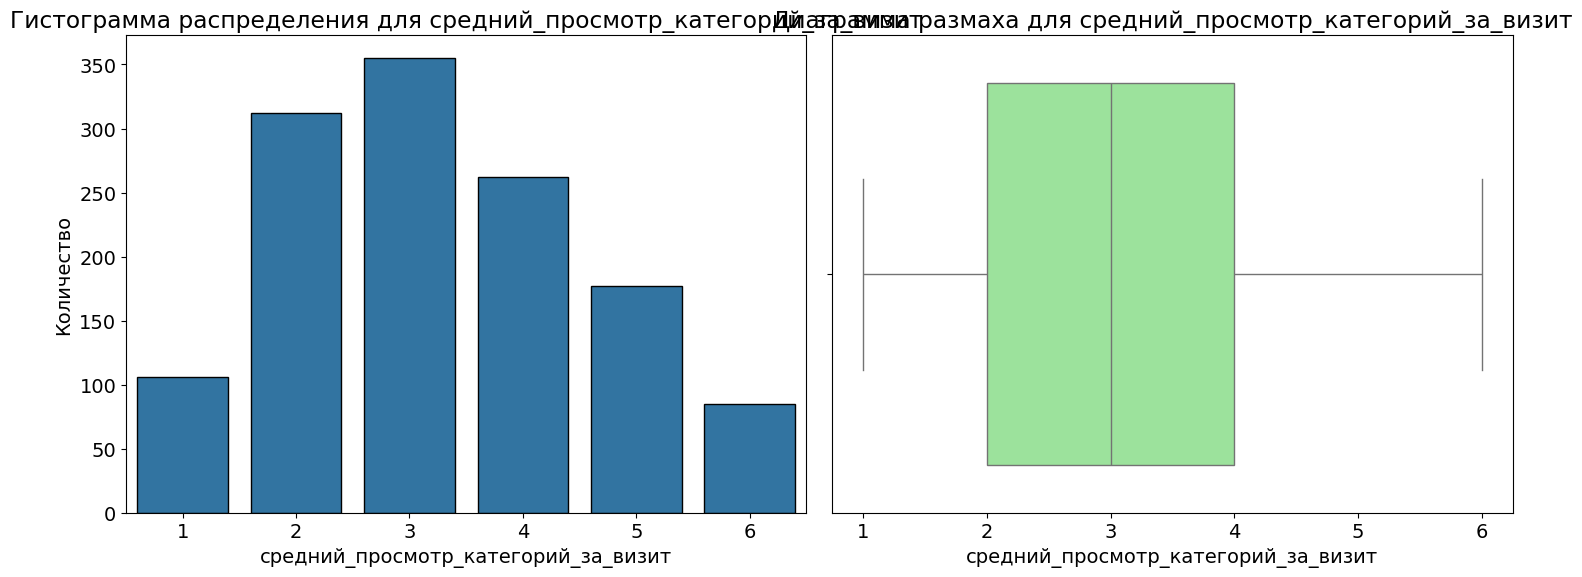

In [ ]:
get_graph_bar(market_file_a, 'средний_просмотр_категорий_за_визит')

In [ ]:
market_file_a['средний_просмотр_категорий_за_визит'].describe()

,средний_просмотр_категорий_за_визит
count,1297.000000
mean,3.267540
std,1.354623
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


Данные по среднему количеству просмотров за визит принимают дискретные целочисленные значения от 1 до 6, со средним просмотром 3-х категорий, что соответствует количеству популярных категорий.

### Признак `неоплаченные_продукты_штук_квартал`

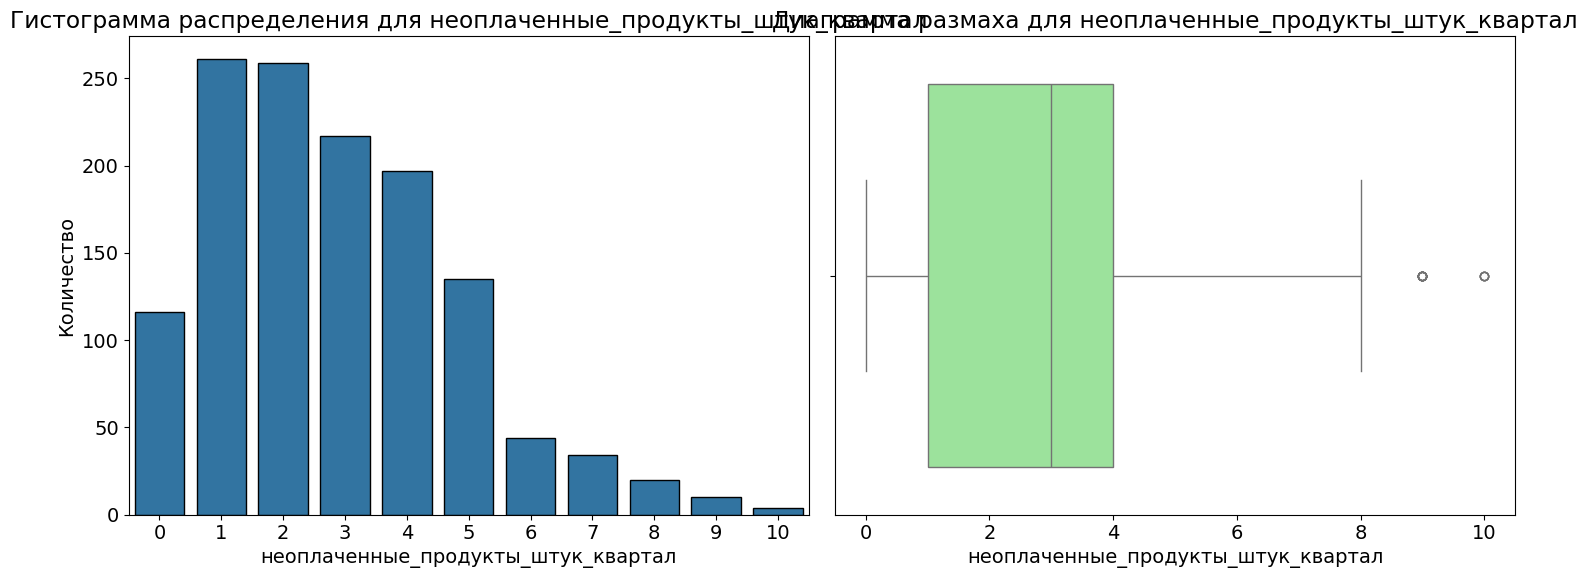

In [ ]:
get_graph_bar(market_file_a, 'неоплаченные_продукты_штук_квартал')

In [ ]:
print(f"Количество клиентов с неоплаченными товарами за квартал больше 8: {market_file_a.loc[market_file_a['неоплаченные_продукты_штук_квартал'] > 8, 'id'].count()}")

Количество клиентов с неоплаченными товарами за квартал больше 8: 14


In [ ]:
market_file_a['неоплаченные_продукты_штук_квартал'].describe()

,неоплаченные_продукты_штук_квартал
count,1297.000000
mean,2.841172
std,1.973451
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,10.000000


В среднем количество неоплаченных товаров за квартал не превышает 3-х. На диаграмме размаха наблюдаются две точки выброса, что составляет 14 клиентов не оплативших больше 8 товаров за квартал, но из-за малого количества данных не станем их исключать.

### Признаки `ошибка_сервиса`

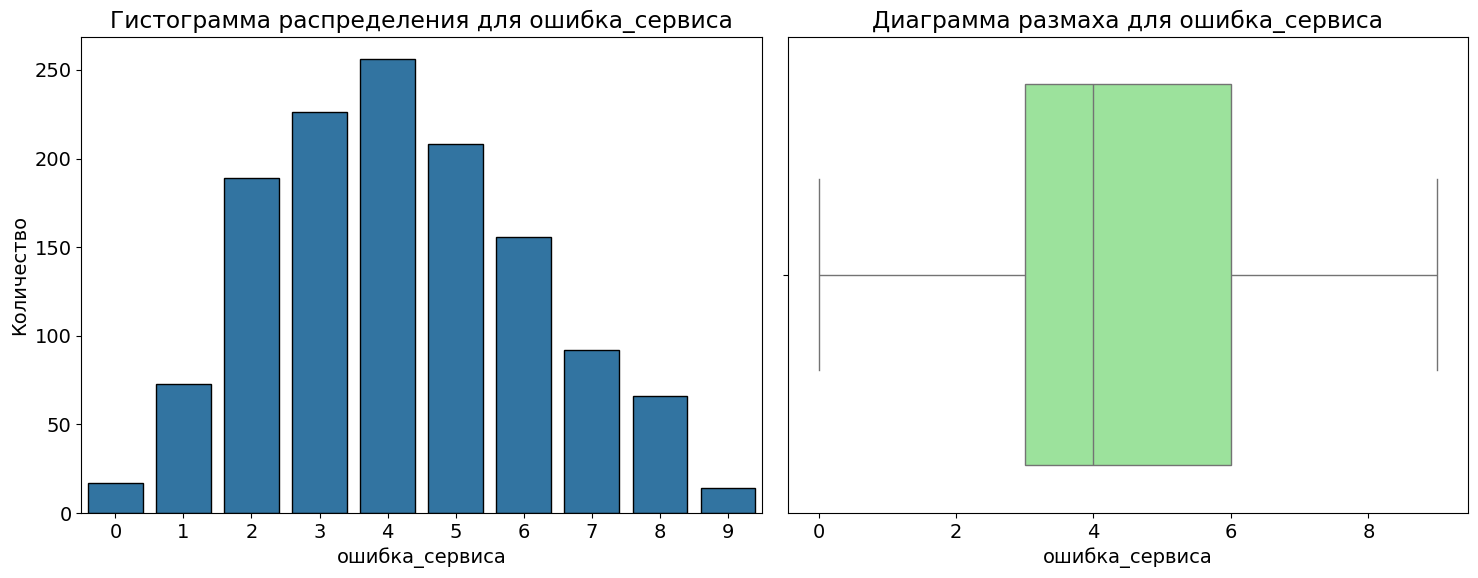

In [ ]:
get_graph_bar(market_file_a, 'ошибка_сервиса')

In [ ]:
market_file_a['ошибка_сервиса'].describe()

,ошибка_сервиса
count,1297.000000
mean,4.184271
std,1.950973
min,0.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,9.000000


В средним пользователь стакивается с четырьмя сбоями за визит, но неизвестен критичность и характер сбоя.

### Признаки `страниц_за_визит`

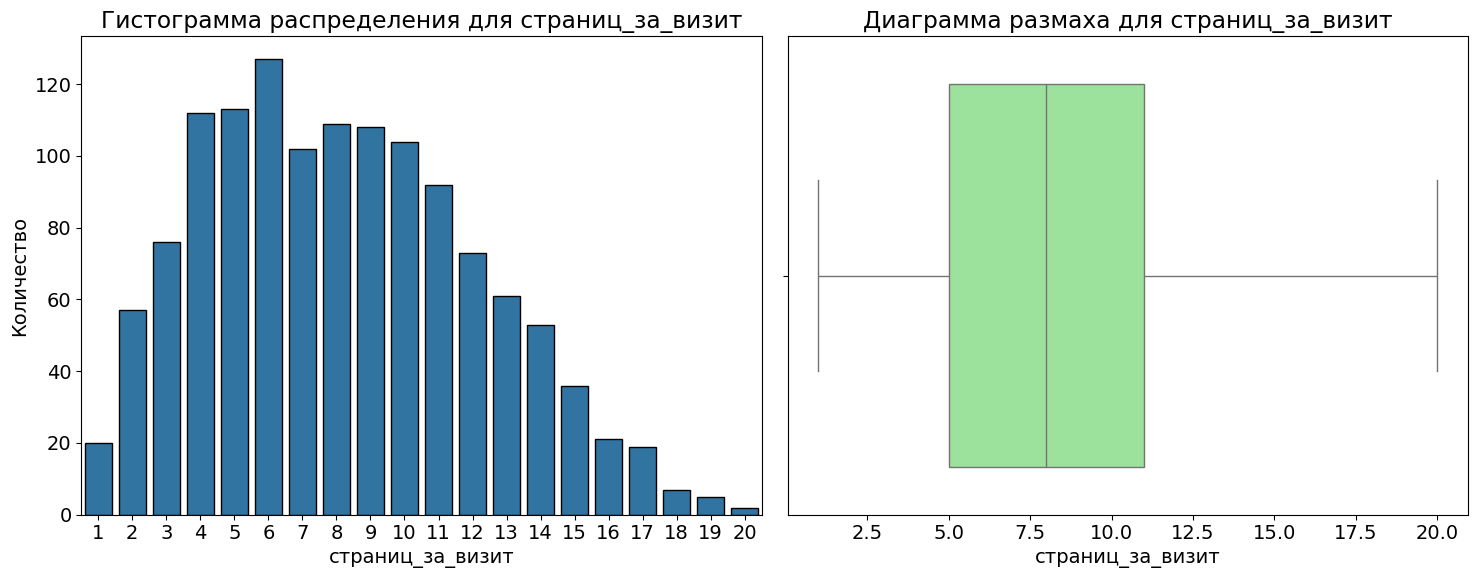

In [ ]:
get_graph_bar(market_file_a, 'страниц_за_визит')

In [ ]:
market_file_a['страниц_за_визит'].describe()

,страниц_за_визит
count,1297.000000
mean,8.186584
std,3.977061
min,1.000000
25%,5.000000
50%,8.000000
75%,11.000000
max,20.000000


В среднем пользователей просматривает более 8 страниц за визит. Это может говорить как о высокой метрике поведенческого фактора так и о негативной, особенно если предположить, что из 8 страниц минимум 4 являются навигационными:

- Главная страница.
- Страница категории.
- Страница целевого интереса (товара).
- Корзина.

## Файл `market_money`

### Признак `выручка`

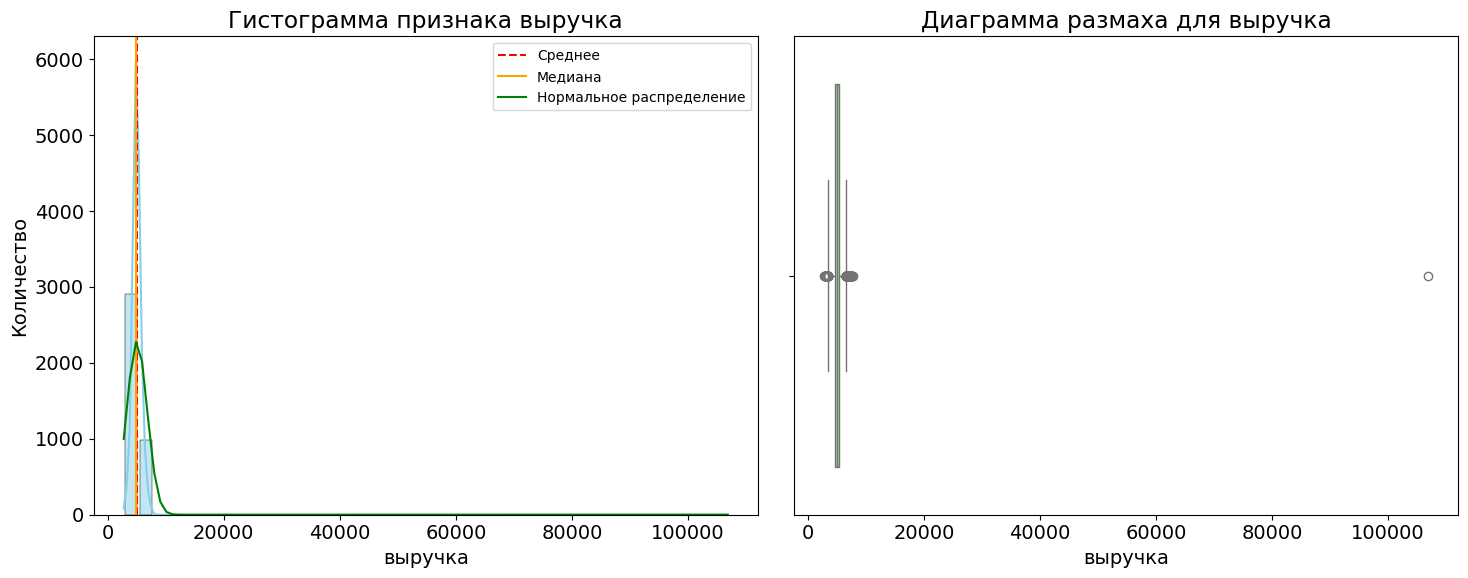

In [ ]:
get_graph_plot(market_money_a, 'выручка')

На графике виден явный выброс, посмотрим на него и исключим его из набора.

In [ ]:
market_money_a.loc[market_money_a['выручка'] > 80000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [ ]:
market_money_a = market_money_a.loc[market_money_a['выручка'] < 80000]

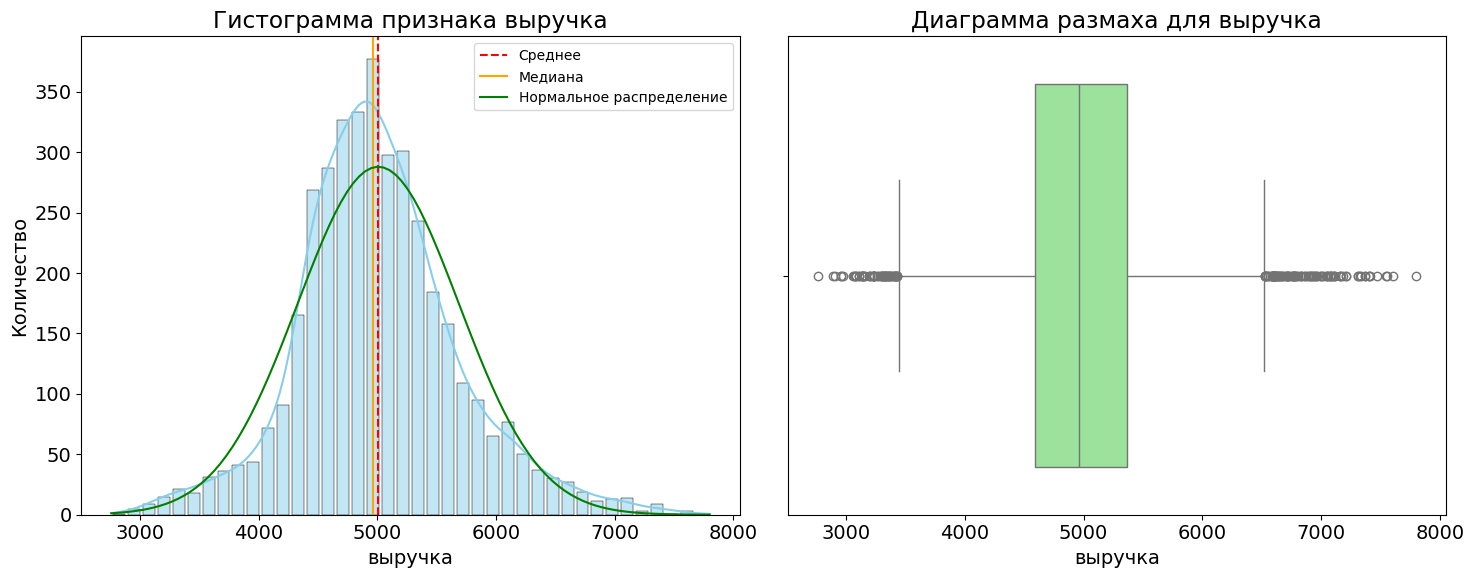

In [ ]:
get_graph_plot(market_money_a, 'выручка')

После удаления аномального значения, данные принимают распределение близкое к нормальному. Не исключено, что удалённое значение может быть реальным, но оно слишком сильно выбивается из общего пула и может исказить предсказательную способность модели.

## Файл `market_time`

### Признак `минут`

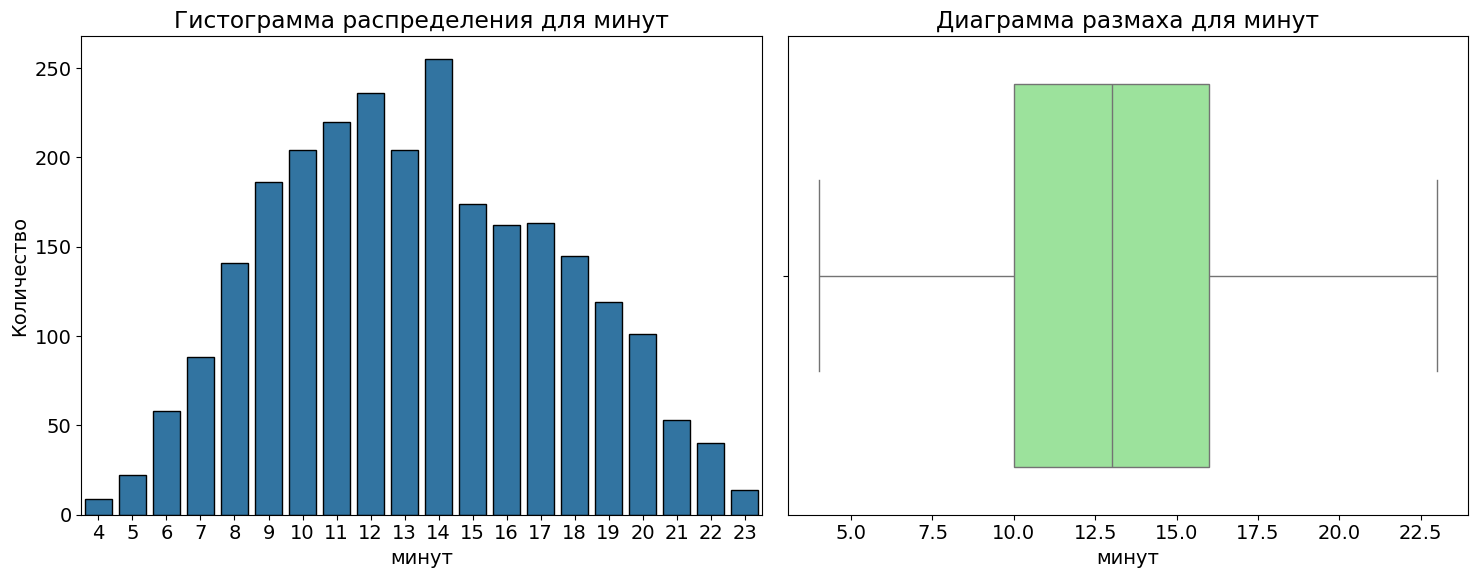

In [ ]:
get_graph_bar(market_time_a, 'минут')

In [ ]:
market_time_a['минут'].describe()

,минут
count,2594.000000
mean,13.340401
std,4.081999
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


Показатели посещаемости сайта распределены близко к нормальному, а так же не  замечено выбросов на крайне низких и высоких показателях времени.

В среднем пользователь затрачивает 13 минут на просмотр сайта. Принимая внимание данные о посещённых страницах за визит, магазин хорошо захватывает внимание клиента, но к сожалению неизвестно время затраченное на оформление заказа и поиск интересующего товара, так как это может говорить о негативной стороне показателя.

## Файл `money`

### Признак `прибыль`

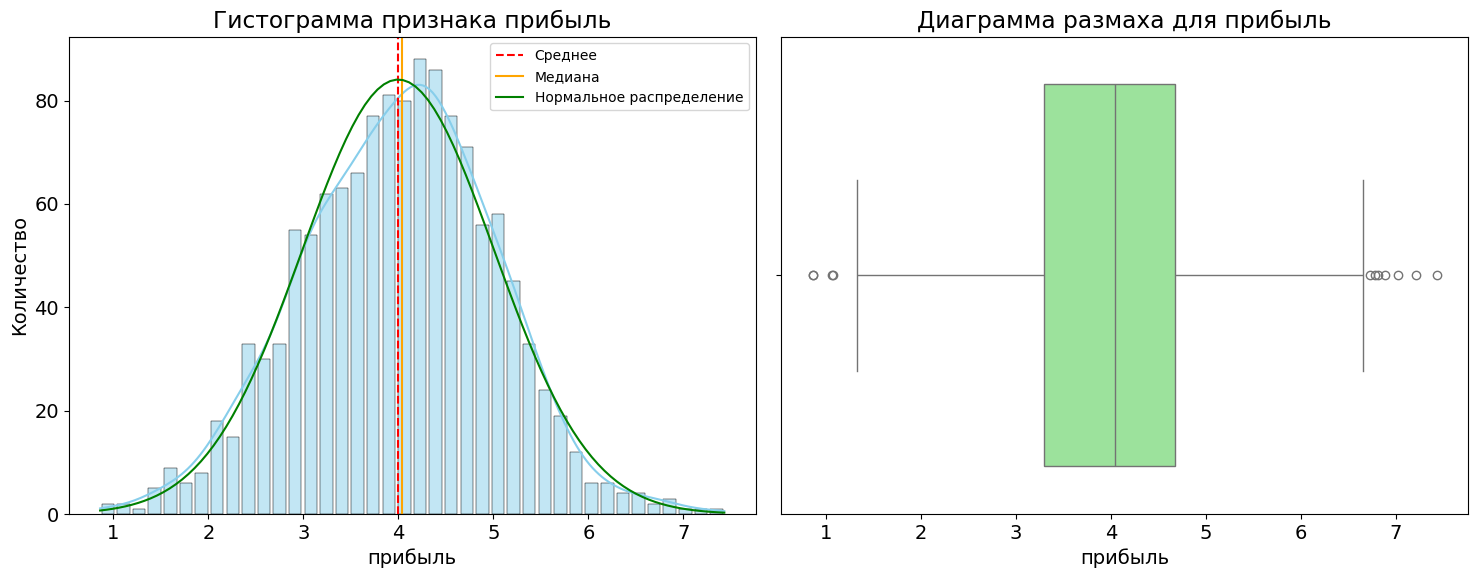

In [ ]:
get_graph_plot(money_a, 'прибыль')

In [ ]:
money_a['прибыль'].describe()

,прибыль
count,1297.000000
mean,3.997610
std,1.010813
min,0.860000
25%,3.300000
50%,4.040000
75%,4.670000
max,7.430000


Распределение данных приближено к нормальному. Диаграмма размаха демонстрирует выбросы с обеих сторон.

## Вывод

Исследовательский анализ показал следующее. Все категориальные признаки имеют ярко выраженный дисбаланс классов из-за специфики задачи мы не можем его устранить, но учтём при построении модели и подберём подходящую метрику оценки.

Показатели магазина на высоком уровне, отмечается высокая заинтересованность и лояльность клиентов как при **посещении сайта**, **покупок не акционных товаров**, **качественных услуг премиум сервиса** так и на **получении маркетинговых сообщений**.

Тревожным сигналом считаю **возраст аккаунтов**, основная масса клиентов зарегистрировалась в один период, возможно стоит провести исследование по возрастным группам и выявить причины отсутствие новых пользователей.

# 4. Объединение данных

Создадим единый датафрейм `market_full` из `market_file.csv`, `market_money.csv`, `market_time.csv` для проведения корреляционного анализа с целью выявить связь признаков к целевым и использовать полученные данные для построения модели.

Для новых признаков добавим префикс `выручка_` и `минуты_`.

In [ ]:
market_money_a_pt = market_money.pivot(index='id', columns='период', values='выручка').add_prefix('выручка_')
market_time_a_pt = market_time.pivot(index='id', columns='период', values='минут').add_prefix('минуты_')

market_full = (
    market_file
    .merge(market_money_a_pt, on='id', how='left')
    .merge(market_time_a_pt, on='id', how='left')
)

market_full = market_full[market_full.get('выручка_текущий_месяц', 0) < 10_000]

market_full.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
6,215354,снизилась,стандарт,да,5.1,3,431,0.23,косметика и аксессуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
7,215355,снизилась,стандарт,нет,4.7,4,284,0.17,товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
8,215356,снизилась,стандарт,да,4.2,4,192,0.14,косметика и аксессуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
9,215357,снизилась,стандарт,да,3.9,5,154,0.00,техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6


In [ ]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1299 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   int64  
 1   покупательская_активность            1299 non-null   object 
 2   тип_сервиса                          1299 non-null   object 
 3   разрешить_сообщать                   1299 non-null   object 
 4   маркет_актив_6_мес                   1299 non-null   float64
 5   маркет_актив_тек_мес                 1299 non-null   int64  
 6   длительность                         1299 non-null   int64  
 7   акционные_покупки                    1299 non-null   float64
 8   популярная_категория                 1299 non-null   object 
 9   средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  ошибка_сервиса                     

# 5. Корреляционный анализ

Проведём корреляционный анализ данных с использованием модуля `phik`, так как не все данные имеют нормальное распределения, а некоторые столбцы содержат категориальные значения.

Так же чтобы не вводить лишний признак трансформируем столбец `id` в индекс. И выделим группу столбцов имеющие числовой тип данных

In [ ]:
market_full.set_index('id', inplace=True)

nc = market_full.select_dtypes(include=['number']).columns
nc = nc.drop(['маркет_актив_тек_мес',
              'средний_просмотр_категорий_за_визит',
              'неоплаченные_продукты_штук_квартал',
              'ошибка_сервиса', 'страниц_за_визит'])

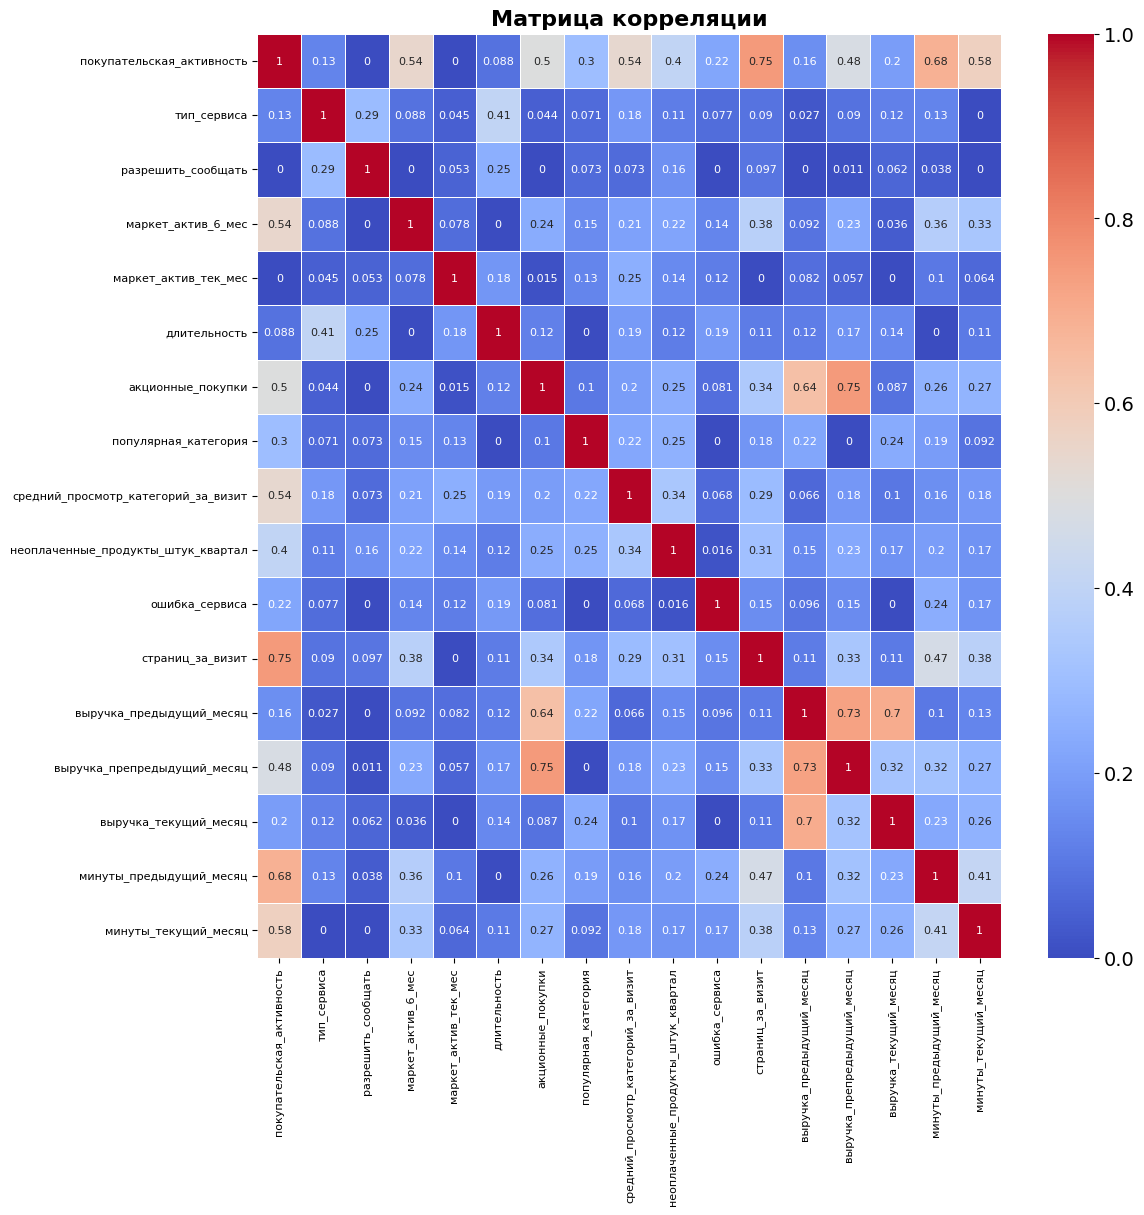

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(market_full.phik_matrix(interval_cols=nc), annot=True, linewidths=0.5, annot_kws={"size": 8}, cmap='coolwarm');

plt.xticks(rotation=90, fontsize=8);
plt.yticks(fontsize=8)
plt.title('Матрица корреляции', fontsize=16, fontweight="bold", color='black');

Степень влияния признаков будем оценивать по шкале Чеддока. Целевой признак `покупательская активность` имеет линейную связь:

- Высокая связь `Страниц за визит` - 0.75
- Заметная связь `Минут предыдущий месяц` - 0.68
- Заметная связь `Маркет актив 6 мес` - 0.55
- Заметная связь `Акционные покупки` - 0.50
- Заметная связь `Средний просмотр категорий за визит` - 0.54
- Заметная связь `Неоплаченные продукты штук квартал` - 0.50
- Умеренная связь `Выручка препредыдуший месяц` - 0.48


Так же можно отметить мультиколленеарность между признаками `выручка препредыдущий месяц` и `выручка предыдущий месяц`. По подготовленной диаграмме Исикавы, заменим эти признаки на новые

- `разница_выручки_предыдущего_месяца`
- `разница_выручки_текущего_месяца`

In [ ]:
market_full['разница_выручки_предыдущего_месяца'] = market_full['выручка_предыдущий_месяц'] - market_full['выручка_препредыдущий_месяц']
market_full['разница_выручки_текущего_месяца'] = market_full['выручка_текущий_месяц'] - market_full['выручка_предыдущий_месяц']

market_full = market_full.drop(['выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц'], axis=1)

Данные успешно заменены повторно выведем матрицу корреляции.

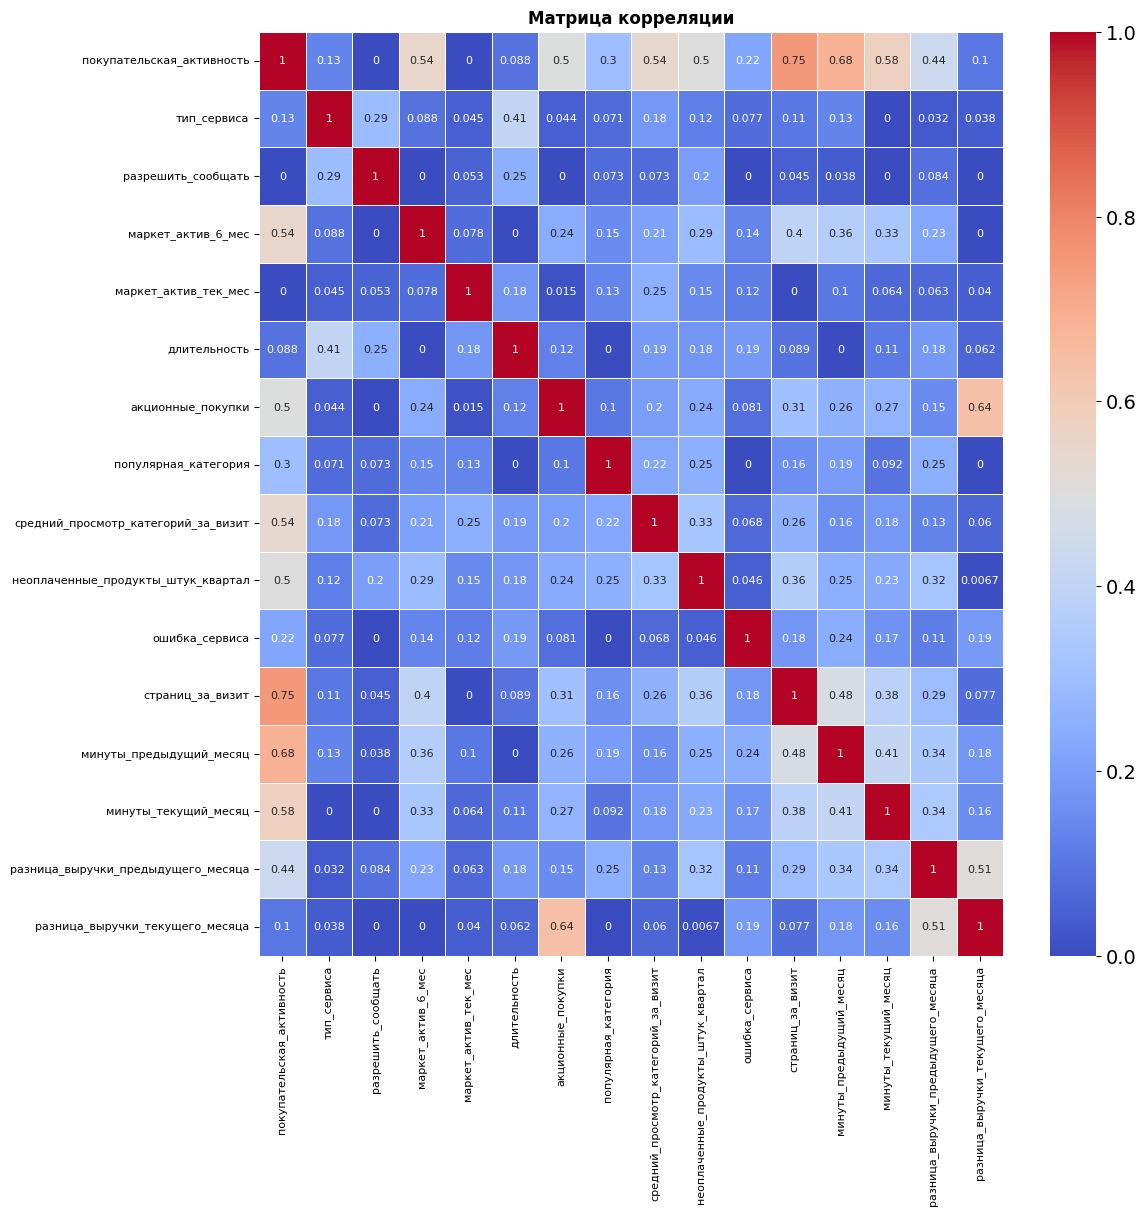

In [ ]:
nc = market_full.select_dtypes(include=['number']).columns

plt.figure(figsize=(12,12))
sns.heatmap(market_full.phik_matrix(interval_cols=nc), annot=True, linewidths=0.5, annot_kws={"size": 8}, cmap='coolwarm');

plt.xticks(rotation=90, fontsize=8);
plt.yticks(fontsize=8)
plt.title('Матрица корреляции', fontsize=12, fontweight="bold", color='black');

При повторном анализе видно, что внесения новых признаков устранило мультиколленеарность.

# 6. Создание Пайплайна

Для создания и поиска эффективной модели будет создан единый пайплайн с подбором гиперпараметров методом `GridSearchCV`. Несмотря на увеличенное количество времени и расчётов подобным методом, данных не так много, а мы сможем подобрать наиболее эффективную модель.

- `KNeighborsClassifier()`
- `DecisionTreeClassifier()`
- `LogisticRegression()`
- `SVC()`

Каждый этап будет разделён на отдельный блок.



## 6.1 Формирование списков

In [ ]:
X = market_full.drop('покупательская_активность', axis=1)
y = market_full['покупательская_активность']

ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = market_full.select_dtypes(include=['number']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f'Размер тренировочной выборки: {X_train.shape}\nРазмер тестовой выборки: {X_test.shape}')

Размер тренировочной выборки: (974, 15)
Размер тестовой выборки: (325, 15)


## 6.2 Подготовка пайплайна

In [ ]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('ord', OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
)

num_pipe = Pipeline(
    [
        ('scaler', MinMaxScaler())
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

## 6.2 Гиперпараметры

In [ ]:
param_grid = [
    {
        'models': [DecisionTreeClassifier()],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),
        'models__kernel': ['rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [ ]:
time_start = time.time()

GridSearch = GridSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring = 'roc_auc',
    n_jobs=-1
)

GridSearch.fit(X_train, y_train)
y_test_pred = GridSearch.predict_proba(X_test)[:, 1]

time_end = time.time()

print(f"Время выполнения: {time_end - time_start:.2f} секунд")
print('Лучшая модель и её параметры:\n\n', GridSearch.best_estimator_)
print()
print('Метрика лучшей модели на тренировочной выборке:', GridSearch.best_score_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Время выполнения: 18.38 секунд
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                  

## Вывод

Для создание модели машинного обучения, был создан общий пайплайн для 4-х моделей и подбором гиперпараметров с проверкой в 5 циклов кросс-валидации.

- DecisionTreeClassifier()
- KNeighborsClassifier()
- LogisticRegression()
- SVC()

Оценкой качества модели была выбрана `ROC-AUC` так как она измеряет способность модели различать два класса, независимо от конкретного порога классификации учитывая как **TPR** так и **FPR**.

Лучшей моделей по результатам `SVC` с коэффициентом `C = 1`. Результат кросс-валидации лучшей модели на тренировочной выборке: 0.913, а на тестовой выборке: 0.916.

# 7. Анализ важности признаков

Оценим степень влияния отдельных признаков на предсказания модели, для этого используем модуль `SHAP`.

In [ ]:
best_model = GridSearch.best_estimator_
svc_model = best_model.named_steps['models']

Xtrain = best_model.named_steps['preprocessor'].fit_transform(X_train)
Xtest = best_model.named_steps['preprocessor'].transform(X_test)

In [ ]:
explainer = shap.Explainer(svc_model.predict_proba, Xtrain)
shap_values = explainer(Xtest)

PermutationExplainer explainer: 326it [05:52,  1.08s/it]


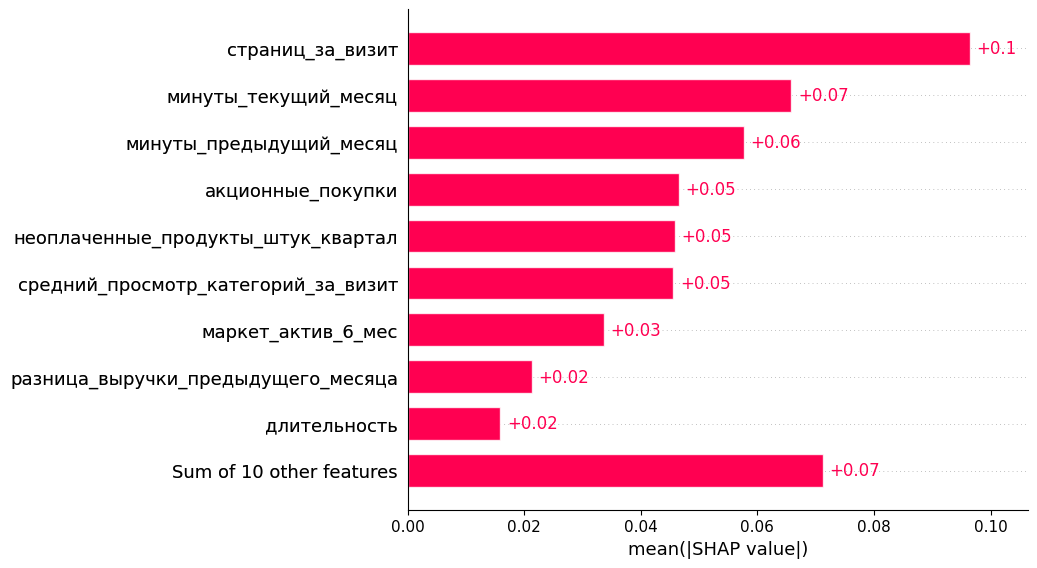

In [ ]:
feature_names = [re.sub(r'^(num__|ohe__|ord__)', '', name) for name in best_model.named_steps['preprocessor'].get_feature_names_out()]
shap.plots.bar(shap.Explanation(values=shap_values[:, :, 1], feature_names=feature_names))
plt.show()

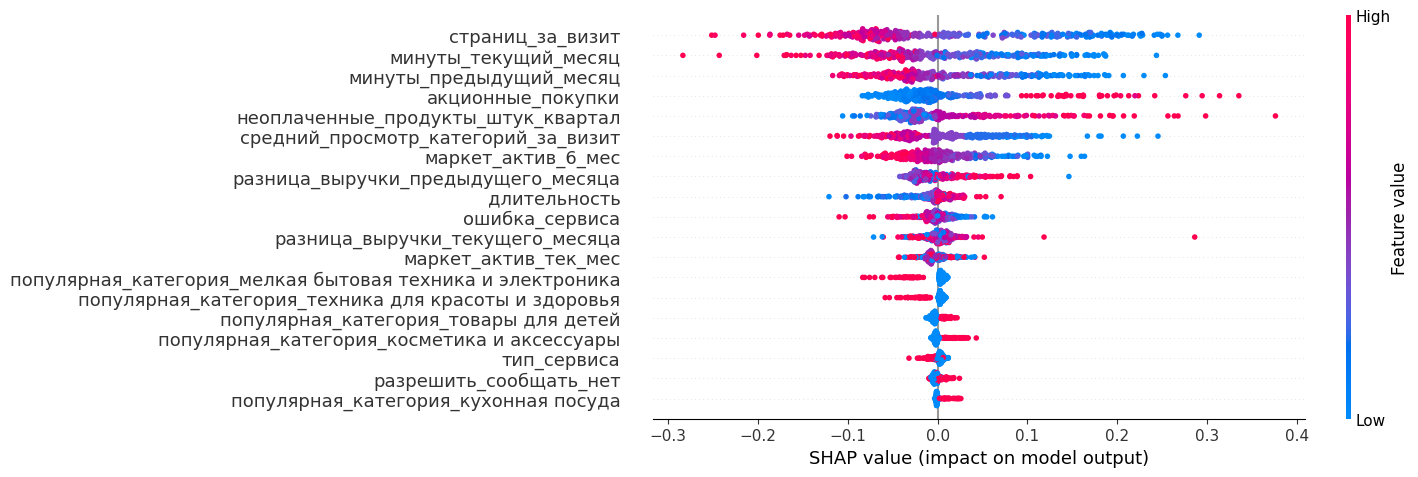

In [ ]:
shap.summary_plot(shap_values[:, :, 1], Xtest, feature_names=feature_names, plot_size=(15, 5))

## Вывод

Анализ столбчатого графика и диаграммы показал, что наибольшее влияние на покупательскую активность оказывают шесть признаков. Рассмотрим возможные причины их значимости:

1. `страниц_за_визит` - Является самым важным признаком, вероятнее всего клиент просматривает страницы интересующей его категории.
2. `минуты_текущий_месяц` - Несмотря на слабую корреляцию с страницами за визит, вероятнее всего клиент подробно изучает страницы предложенных товаров или подбирает фильтры если они предусмотрены.
3. `минуты_предыдущий_месяц` - Аналогично предыдущему признаку, но за другой период.
4. `акционные_покупки` - Несмотря на меньшее влияние на целевой признак, логичнее предположить, что клиентов с высокой долей акционных покупок имеет смысл выделить в отдельную категорию.
5. `неоплаченные_продукты_штук_квартал` - Нельзя считать признак однозначно негативным, так как часть пользователей используют корзину как закладки или для мониторинга цен, чтобы совершить покупку в будущем.
6. `средний_просмотр_категорий_за_визит` - Имеет идентичное влияние на целевую переменную как и `неоплаченные_продукты_штук_квартал`.

Остальные признаки также оказывают влияние, но в значительно меньшей степени.

# 8. Сегментация покупателей

Исследуем детально сегмент покупателей основанный на вероятности присвоения класса, для этого создадим новый столбец для финального датасета с вероятностью присвоения из обученной модели и оценим как распределена вероятность.

В сегменте выделим наиболее прибыльных клиентов с высоким риском снижения покупательской активности.

In [ ]:
X_full = market_full.drop(columns=['покупательская_активность'])

market_resserch = market_full
market_resserch['вероятность_снижения'] = (GridSearch.best_estimator_.predict_proba(X_full)[:, 1] * 100).round(2)
market_resserch.reset_index(inplace=True)

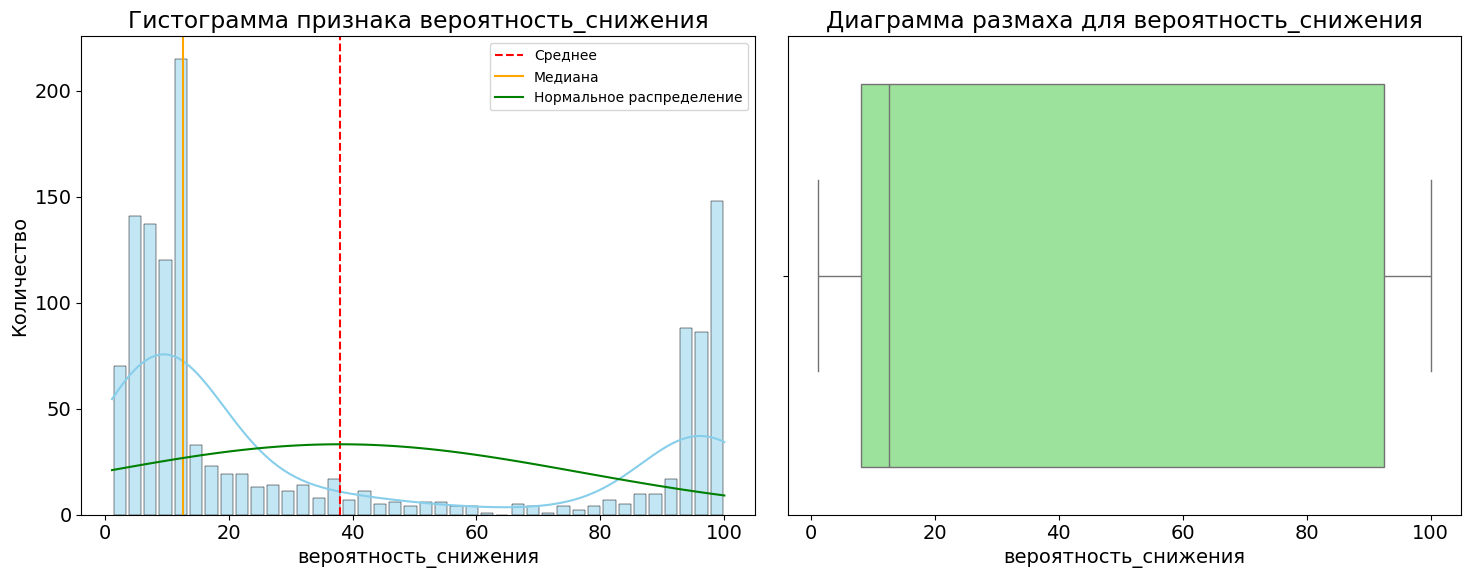

In [ ]:
get_graph_plot(market_resserch, 'вероятность_снижения')

На графике видно, что рост шанса присвоения класс 1 (снизилась) начинается с отметки в 80%. С этого порога отберём группу клиентов и изучим данные детальнее.

Проанализируем самую прибыльную группу пользователей магазина. Выборку составим на основе прибыльности клиента выше среднего значения на 5% из файла `money` и сравним показатели признаков оказавших наибольшее влияние.

In [ ]:
mean_upper = money[money['прибыль'] > money['прибыль'].mean() * 1.05]

print(f"Всего {len(mean_upper)} ({len(mean_upper) / len(money)*100:.0f} %) клиентов с прибыльность от {(money['прибыль'].mean()) * 1.05:1f}")

Всего 570 (44 %) клиентов с прибыльность от 4.196462


In [ ]:
actual_clients = market_resserch[market_resserch['id'].isin(mean_upper['id'])]

## Ключевой признак `страниц_за_визит`

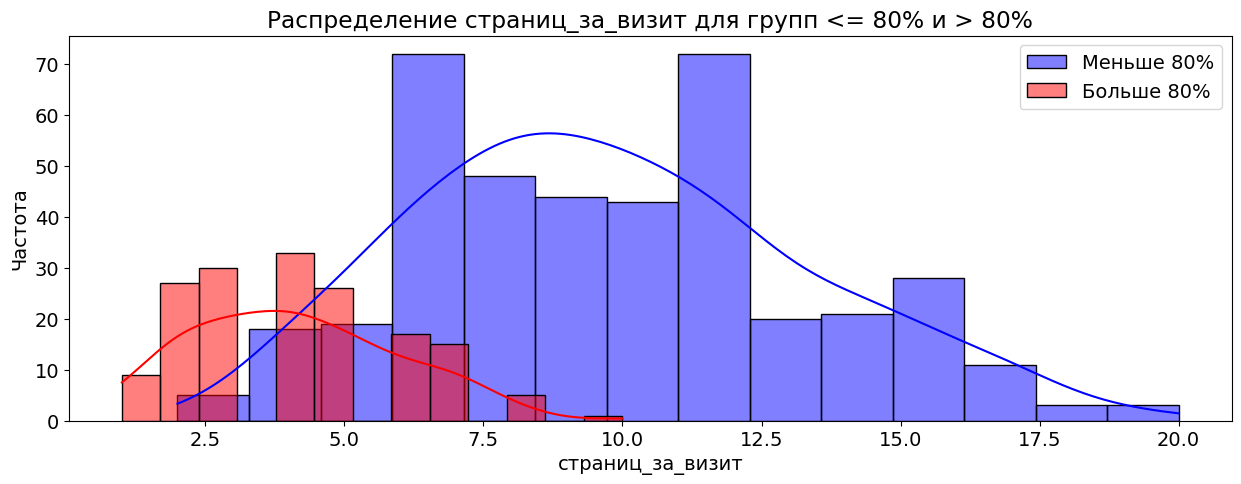

In [ ]:
get_graph_plot_ml(actual_clients, 'страниц_за_визит', 80)

Наиболее важный ключевой признак демонстрирует явные различия в поведении клиентов.

- Группа клиентов с высоким риском не склонна просматривать весь ассортимент магазина, а рассчитывает найти интересующую позицию раньше в противном случае ищет в другом месте.
- Таргетинговая реклама или meta-описание имеет слишком высокий охват, что привлекает большее число клиентов не по целевому запросу.
- Ассортимент магазина слишком большой чтобы клиент смог найти то что ему нужно.

## Ключевой признак `минуты_текущий_месяц`

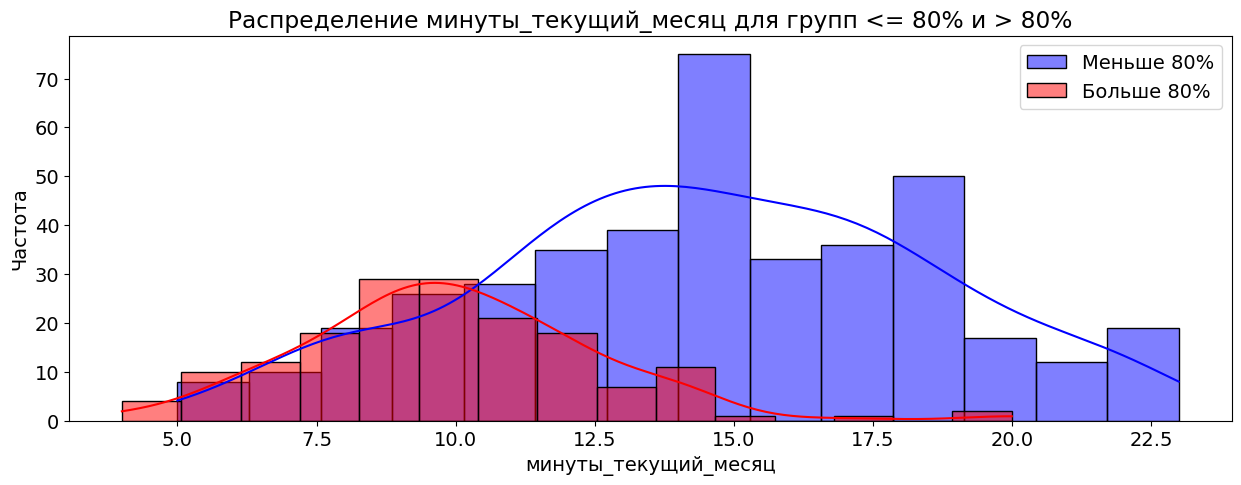

In [ ]:
get_graph_plot_ml(actual_clients, 'минуты_текущий_месяц', 80)

Следующий ключевой признак отражает схожую картину. Можно предположить, что рискованной группе в большинстве случаев достаточно 10 минут для принятия решения продолжать поиск или покинуть магазин.

## Ключевой признак `минуты_предыдущий_месяц`

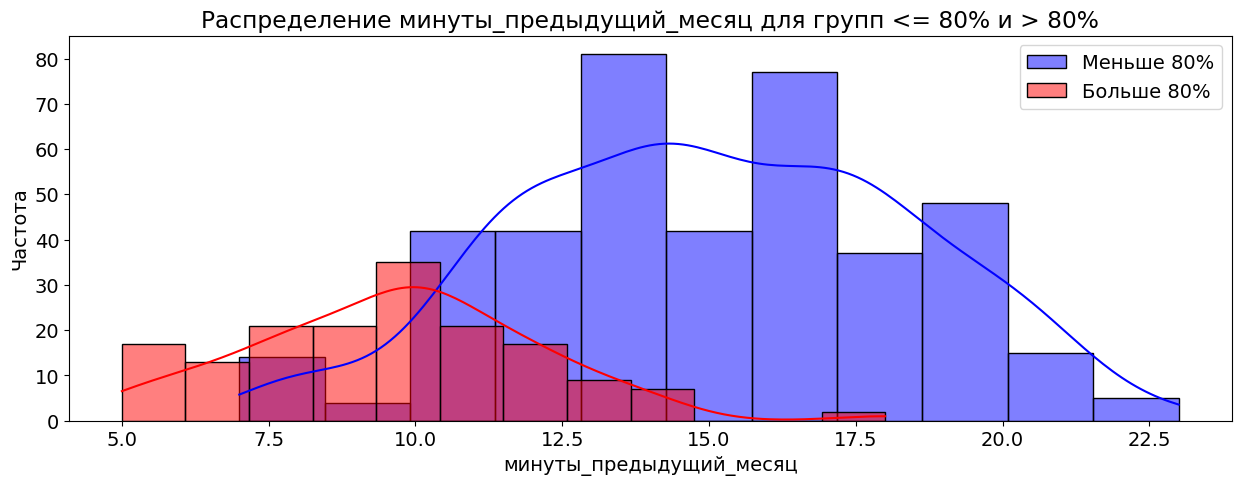

In [ ]:
get_graph_plot_ml(actual_clients, 'минуты_предыдущий_месяц', 80)

Показатели предыдущего месяца имеют более негативную картину, возможно магазин предпринимал попытки улучшить захват внимания клиента. И результаты имеют положительную динамику.

## Ключевой признак `акционные_покупки`

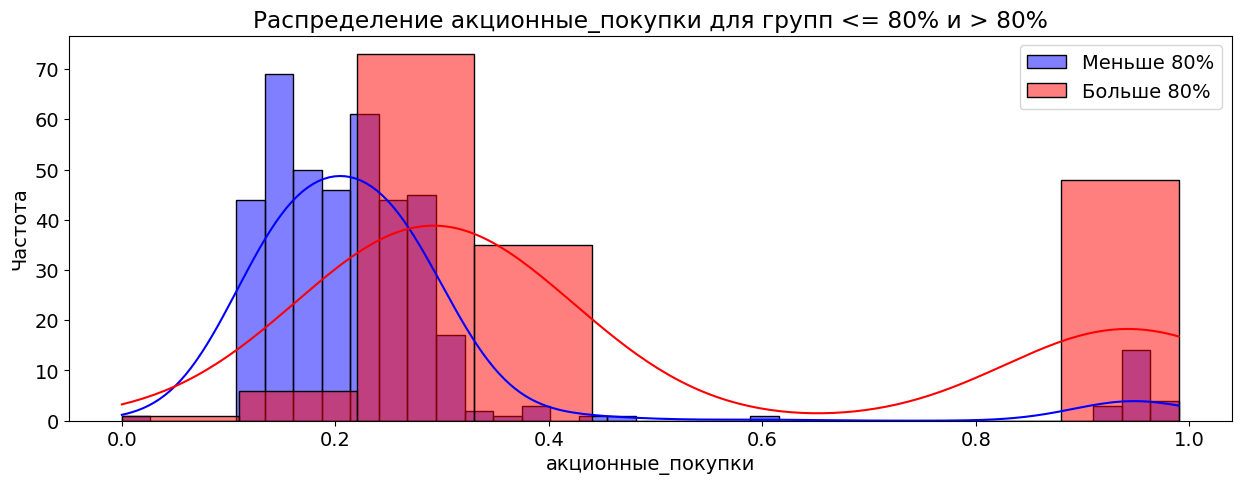

In [ ]:
get_graph_plot_ml(actual_clients, 'акционные_покупки', 80)

Достаточно сильное влияние товаров по акции на рискованную группу. Рекомендуется усилить коммуникацию с такими клиентами, а так же вередить систему персональных предложений на другую категорию и брошенные корзины.

## Ключевой признак `неоплаченные_продукты_штук_квартал`

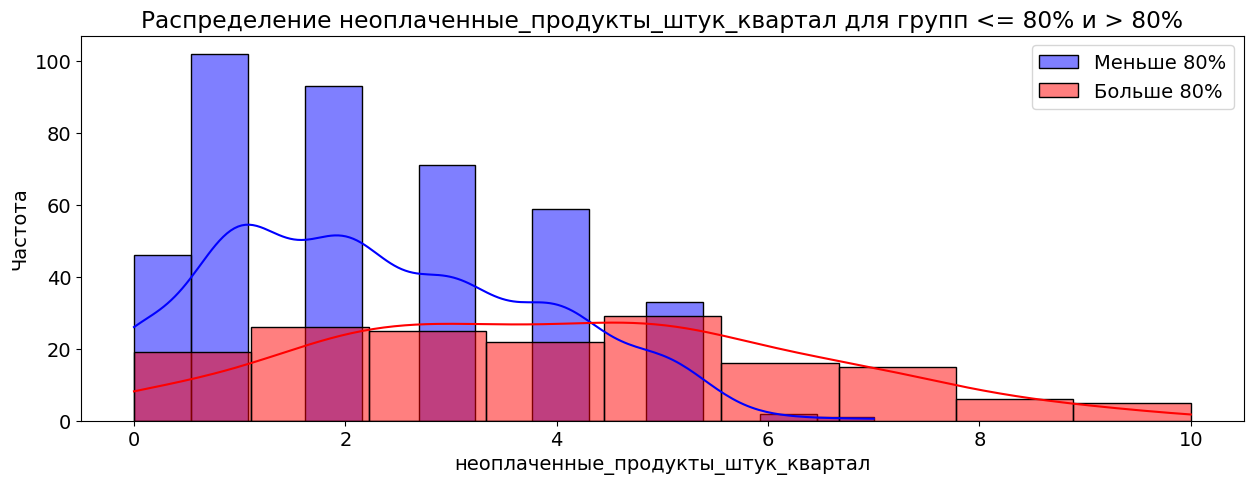

In [ ]:
get_graph_plot_ml(actual_clients, 'неоплаченные_продукты_штук_квартал', 80)

Ранее выдвинутое предположение подтвердилось, часть клиентов действительно откладывают часть товаров в корзину, возможно по причине ожидания снижения цены.

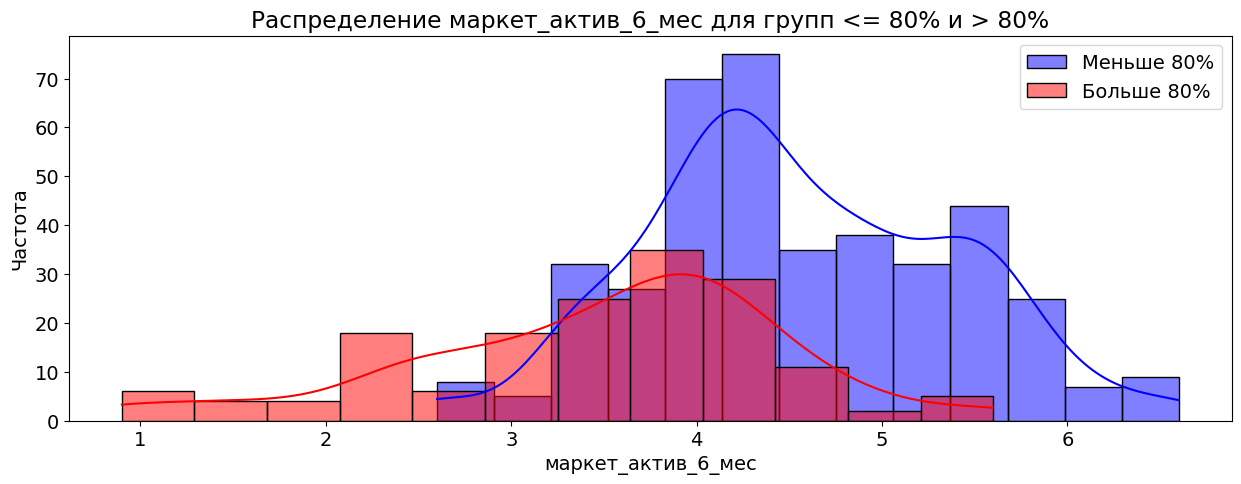

In [ ]:
get_graph_plot_ml(actual_clients, 'маркет_актив_6_мес', 80)

По данным маркетинговой активности за пол года, можно сделать предположение, что магазин имеет функционал связи с рискованной группой. Количество сообщений напоминает уведомления-напоминания, что навряд ли оказывает эффект.

## Вывод

Были сопоставлены и исследованы две наиболее прибыльные группы клиентов по средней прибыли где модель предсказала снижение покупательской активности более 80% и теми у кого менее 80%.

Потенциально магазин может иметь проблемы в следующих деталях:

- Плохо настроена фильтрация на сайте клиенты не готовы просматривать весь каталог.
- Магазин затрачивает ресурсы на привлечения не целевой аудитории.

По результат исследования можно сформировать предположительный портрет клиента.

- Клиент просматривает лишь интересующие его товары.
- Клиент отслеживает изменение цен.
- Клиент не склонен совершать импульсивные покупки и планирует расходы.
- Клиент игнорирует маркетинговые сообщения после чего магазин теряет к нему интерес.

Рекомендации:

- Следует проанализировать глубину купленных товаров, долго ли приходится просматривать каталог от момента захода до покупки.
- Провести опрос клиентов удобна ли навигация на сайте.
- Отслеживать срок добавления товара в корзину и предлагать сниженные цены на такие товары или предлагать аналог.

# 9. Общий вывод

Интернет-магазином было предоставлено четыре файла содержащие данные поведении и финансовых показателях клиентов.

## Задача
Целью работы была разработка модели машинного обучения для предсказания снижения покупательской активности постоянных клиентов и разработке персональных решений для данной категории пользователей.

## Исходные данные
Исходные данные имели высокое качество, во время анализа не было обнаружено, пропусков, большого количество выбросов и дубликатов.

- Все столбцы соответствовали хранимому типу.
- Немногочисленные неявные дубликаты устранены.
- Названия столбцов приведены к змеиному регистру.

## Модель машинного обучения
Для подбора лучшей модели машинного обучения был произведён корреляционный анализ признаков для оценки зависимости и выявления мультиколленеарности.

Разработка модели состояла из создания общего пайплайна для проверки четырёх моделей классификации с подбором гиперпараметров и проверкой кросс-валидацией метрикой ROC-AUC. Наилучшая модель `SVC` она показала лучшее качество с коэффициентом `C = 1`.

Лучше всего покупательскую активность отражают поведенческие факторы клиента. Одним из ключевых факторов можно считать акционные покупки, стоит реализовать систему персональных цен во время скроллинга страниц и внутри корзины.